In [1]:
import pandas as pd
import numpy as np

mitbih_test = pd.read_csv('~/Documents/ecg_classifier/data/mitbih_test.csv', header = None, sep = ',')
mitbih_train = pd.read_csv('~/Documents/ecg_classifier/data/mitbih_train.csv', header = None, sep = ',')
ptbdb_abnormal = pd.read_csv('~/Documents/ecg_classifier/data/ptbdb_abnormal.csv', header = None, sep = ',')
ptbdb_normal = pd.read_csv('~/Documents/ecg_classifier/data/ptbdb_normal.csv', header = None, sep = ',')

In [31]:
from keras.utils import np_utils

def get_data(dataset):
    y = dataset[187].reset_index(drop = True)
    X = dataset.drop(columns = 187).reset_index(drop = True)
    return np.array(X), np.array(y)

mitbih_train = mitbih_train.loc[mitbih_train[187] != 0]
mitbih_test = mitbih_test.loc[mitbih_test[187] != 0]

X_train, y_train = get_data(mitbih_train)
X_test, y_test = get_data(mitbih_test)

#X_train = decimate(X_train, 3, axis=1, zero_phase=True)
#X_test = decimate(X_test, 3, axis=1, zero_phase=True)

X_train = X_train / np.std(X_train, axis=1).reshape(-1,1)
X_test = X_test / np.std(X_test, axis=1).reshape(-1,1)

X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [32]:
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Activation, Add, Conv1D, MaxPooling1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense, Softmax, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

K.clear_session()

inp = Input(shape=X_train.shape[1:])
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [33]:
import math 

batch_size = 300
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = X_train.shape[0]//(10000 * batch_size) 
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Train on 15083 samples, validate on 3774 samples
Epoch 1/30
15083/15083 [==============================] - 8s 501us/step - loss: 0.6582 - accuracy: 0.7680 - val_loss: 0.3001 - val_accuracy: 0.8990
Epoch 2/30
15083/15083 [==============================] - 7s 465us/step - loss: 0.2394 - accuracy: 0.9185 - val_loss: 0.1917 - val_accuracy: 0.9277
Epoch 3/30
15083/15083 [==============================] - 7s 464us/step - loss: 0.1608 - accuracy: 0.9480 - val_loss: 0.1448 - val_accuracy: 0.9481
Epoch 4/30
15083/15083 [==============================] - 7s 463us/step - loss: 0.1094 - accuracy: 0.9659 - val_loss: 0.1210 - val_accuracy: 0.9576
Epoch 5/30
15083/15083 [==============================] - 8s 526us/step - loss: 0.0867 - accuracy: 0.9732 - val_loss: 0.1161 - val_accuracy: 0.9616
Epoch 6/30
15083/15083 [==============================] - 8s 518us/step - loss: 0.0815 - accuracy: 0.9733 - val_loss: 0.1111 - val_accuracy: 0.9626
Epoch 7/30
15083/15083 [==============================] - 7s 48

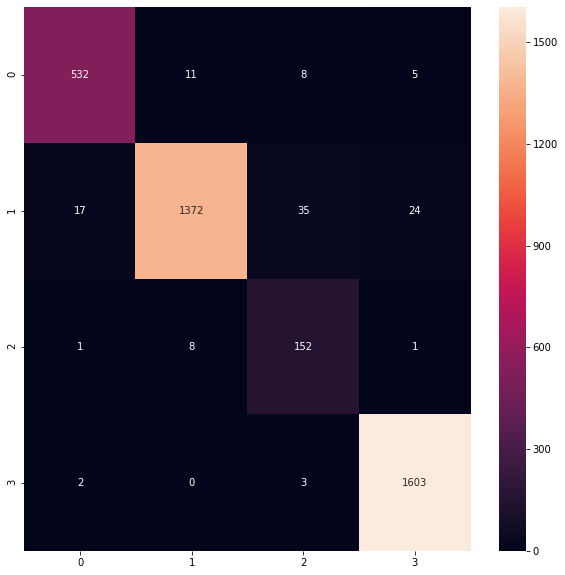

In [58]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

y_pred = model.predict(X_test)
cfm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#cfm = cfm / cfm.astype(np.float).sum(axis=1)

plt.figure(figsize=(10, 10))
sn.heatmap(cfm, annot=True, fmt='d')

plt.show()

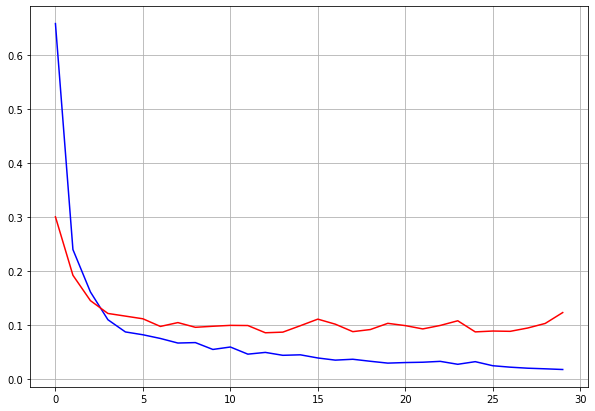

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.grid(True)
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()

In [89]:
M = mitbih_train.values
X = M[:, :-1]
y = M[:, -1].astype(int)

C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

x = np.arange(0, 187)*8/1000

plt.figure(figsize=(10,7))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [90]:
classes = {0 : 'Normal, Left/Right bundle branch block, Atrial escape, Nodal escape',
           1 : 'Atrial premature, Aberrant atrial premature, Nodal premature, Supra-ventricular premature',
           2 : 'Premature ventricular contraction, Ventricular escape',
           3 : 'Fusion of ventricular and normal',
           4 : 'Paced, Fusion of paced and normal, Unclassifiable'}

class_c = { 0:'N',1:'S', 2:'V', 3:'F', 4:'Q'}

In [130]:
def get_report(ecg):
    progs = model.predict(ecg)[0]
    rep = []
    for ind, v in enumerate(progs):
        rep.append('{:.16f}'.format(float(v)))
        rep.append(classes.get(ind))
    return rep
        
s = get_report(X_train[6314][np.newaxis,:,:])
s

['0.0000000000051507',
 'Normal, Left/Right bundle branch block, Atrial escape, Nodal escape',
 '0.0000000023476625',
 'Atrial premature, Aberrant atrial premature, Nodal premature, Supra-ventricular premature',
 '0.9999929666519165',
 'Premature ventricular contraction, Ventricular escape',
 '0.0000069843345045',
 'Fusion of ventricular and normal',
 '0.0000000031213674',
 'Paced, Fusion of paced and normal, Unclassifiable']

In [149]:
X_train.shape

(15083, 187, 1)

In [133]:
mitbih_train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
72471,1.000000,0.666667,0.100457,0.036530,0.073059,0.050228,0.018265,0.105023,0.132420,0.091324,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
72472,0.983696,1.000000,0.331522,0.000000,0.108696,0.163043,0.130435,0.190217,0.288043,0.222826,...,0.461957,0.483696,0.500000,0.494565,0.510870,0.51087,0.505435,0.472826,0.434783,1.0
72473,1.000000,0.911504,0.216814,0.000000,0.101770,0.199115,0.176991,0.194690,0.252212,0.238938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
72474,0.090498,0.126697,0.217195,0.361991,0.461538,0.556561,0.443439,0.434389,0.452489,0.511312,...,0.122172,0.131222,0.140271,0.158371,0.176471,0.20362,0.212670,0.000000,0.000000,1.0
72475,0.961111,1.000000,0.551852,0.101852,0.040741,0.085185,0.094444,0.088889,0.085185,0.070370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.0


In [150]:
model.save('ecg_classifier.h5')

In [135]:
y

array([1, 1, 1, ..., 4, 4, 4])

In [136]:
decimate(X_train, 3, axis=0, zero_phase=True)

NameError: name 'decimate' is not defined

In [0]:
X_train.shape[1:]

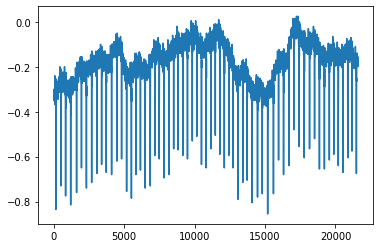

In [155]:
sample = pd.read_csv('~/Documents/ecg_classifier/data/samples.csv', header = None)
plt.plot(sample[1])
plt.show()

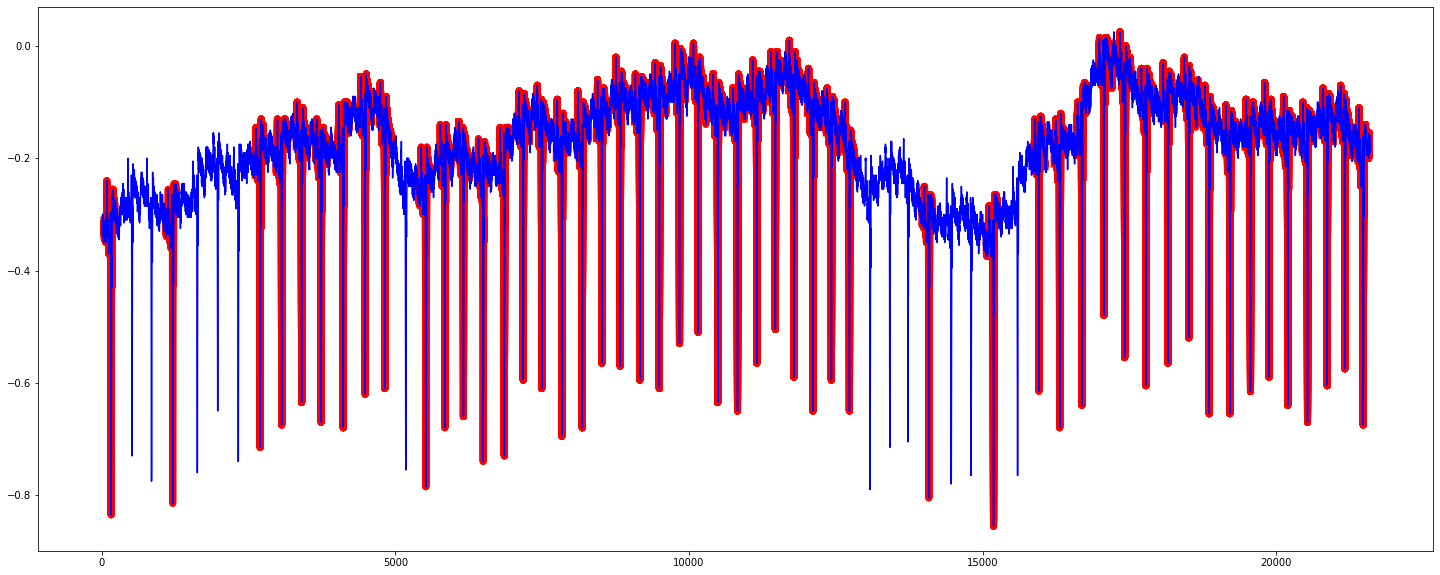

In [156]:
def get_plot_with_results(sample, threshold):
    pat = []
    for ind,a in enumerate(sample):
        if ind+187 > len(sample):
            break
        interval = sample[ind:ind+187][:,np.newaxis][np.newaxis,:,:]
        progs = model.predict(interval)
        if max(progs[0]) > threshold:
            pat.append([list(range(ind,ind+187)), interval])
            #print(classes.get(progs[0].argmax()) + str(max(progs[0])))

    plt.figure(figsize = (25,10))
    for a in pat:
        plt.plot(a[0], a[1].flatten(), color = 'r', linewidth=7.0)

    plt.plot(sample, color = 'b')
    plt.show()
    
    
get_plot_with_results(sample[1], 0.7)

In [0]:
for a in range(10):
    thr = a/10
    get_plot_with_results(sample, thr)

In [0]:
model.layers[-2].get_weights()

In [0]:
preds = model.predict(X_train[30][np.newaxis,:,:])
last_conv_layer = model.get_layer('dense_3')
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
grads = K.gradients(output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_train[30][np.newaxis,:,:]])

for i in range(187):
    conv_layer_output_value[i] *= pooled_grads_value[i]

In [0]:
print(pooled_grads_value)
print(conv_layer_output_value.shape)

In [0]:
from keras import models

layer_names = []
for layer in model.layers[1:]:
    layer_names.append(layer.name)
    
layer_outputs = [layer.output for layer in model.layers[1:]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
activations = activation_model.predict(X_train[30][np.newaxis,:]) 

for ln,la in zip(layer_names, activations):
    plt.matshow(la[0,:,:], cmap='viridis')
    plt.title(ln)
    plt.show()

In [0]:
activations[25].shape

In [0]:
activations[0][0,:,:].shape

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

ecg = pd.read_csv('~/Documents/ecg_classifier/data/samples.csv', header = None)

plt.figure(figsize=(50,7))
plt.plot(ecg[0], ecg[1])
plt.show()

In [0]:
history.values

In [181]:
from keras.models import load_model
import pandas as pd
import numpy as np

def load_nn(path):
    return load_model(path)

def get_results(ecg_file, threshold):
    model = load_nn('ecg_classifier.h5')
    ecg = pd.read_csv(ecg_file, header = None)
    pat = []
    for ind,a in enumerate(ecg[1]):
        if ind+187 > len(ecg[1]):
            break
        interval = ecg[1][ind:ind+187][:,np.newaxis][np.newaxis,:,:]
        progs = model.predict(interval)
        if max(progs[0]) > threshold:
            pat.append([list(ecg[0][ind:ind+187].values), list(ecg[1][ind:ind+187].values)])

    return list(map(lambda x, y: [x,y], ecg[0], ecg[1]))

get_results('~/Documents/ecg_classifier/data/samples_min.csv', 0.7)

2],
 [0.1, -0.31],
 [0.10300000000000001, -0.33],
 [0.106, -0.325],
 [0.10800000000000001, -0.32],
 [0.111, -0.33],
 [0.114, -0.34],
 [0.11699999999999999, -0.34],
 [0.11900000000000001, -0.335],
 [0.122, -0.345],
 [0.125, -0.33],
 [0.128, -0.315],
 [0.131, -0.32],
 [0.133, -0.315],
 [0.136, -0.32],
 [0.139, -0.32],
 [0.142, -0.33],
 [0.14400000000000002, -0.345],
 [0.147, -0.34],
 [0.15, -0.345],
 [0.153, -0.34],
 [0.156, -0.345],
 [0.158, -0.335],
 [0.161, -0.325],
 [0.16399999999999998, -0.315],
 [0.16699999999999998, -0.31],
 [0.16899999999999998, -0.31],
 [0.172, -0.33],
 [0.175, -0.33],
 [0.17800000000000002, -0.33],
 [0.18100000000000002, -0.345],
 [0.183, -0.35],
 [0.18600000000000003, -0.345],
 [0.18899999999999997, -0.34],
 [0.192, -0.335],
 [0.19399999999999998, -0.32],
 [0.19699999999999998, -0.31],
 [0.2, -0.3],
 [0.203, -0.315],
 [0.20600000000000002, -0.315],
 [0.20800000000000002, -0.315],
 [0.21100000000000002, -0.315],
 [0.214, -0.31],
 [0.217, -0.325],
 [0.2189999999